In [1]:
import os
import shutil

import numpy as np
import pandas as pd
from skimage.morphology import skeletonize
from PIL import Image
import cv2
import re
import glob

from skorch import NeuralNetClassifier
from skorch.callbacks import LRScheduler, Checkpoint, EpochScoring, EarlyStopping
from skorch.dataset import Dataset
from skorch.helper import predefined_split
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from pathlib import Path
import tensorflow as tf
from tensorflow import keras
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn import metrics
from tqdm import tqdm

from utils import checksum, process_skeletonize, determine_image_center, ring_region_mask

1. Create a dataframe with image id, race, and number of non-zero pixels in each radius. Repeat for skeletonized images.

In [2]:
def image_center_from_id(QA_csv, img_id, img_size):
    img_row = QA_csv[QA_csv['img_id'] == img_id] # check if string
    
    y_og = img_row['y'].reset_index(drop=True)[0]
    x_og = img_row['x'].reset_index(drop=True)[0]
    
    x_pos = (80 + y_og) * img_size[1]/640 # x size is 640, cropped that way
    y_pos = (x_og)* img_size[0]/480 # y size is 480 (also, height is first in img size tuple, so the 0)
    
    disk_center = (int(x_pos), int(y_pos))
    
    return disk_center

In [3]:
def load_QA_csv(optic_disk_csv = "/users/riya/race/optic_disk/DeepROP/quality_assurance/QA.csv"):
    QA_csv = pd.read_csv(optic_disk_csv)
    
    QA_csv.columns.values[0] = "img_id"
    QA_csv.columns = QA_csv.columns.to_series().apply(lambda x: x.strip())
    QA_csv[['img_id', 'Full path', 'x', 'y', 'is_posterior']]

    QA_csv = QA_csv[QA_csv['is_posterior'] == True]
    
    return QA_csv

In [2]:
def image_from_id(img_path, path_name):
    arr = np.array(Image.open(img_path + path_name))
    resized = cv2.resize(arr, (256,256))
    channels = np.repeat(resized[:, :, np.newaxis], 3, axis=2).reshape((256,256,3))
    
    return channels

In [1]:
def get_race_from_id(img_id, race_csv_path):

    race_data = pd.read_csv(race_csv_path)
    img_row = race_data.loc[race_data['image_id'] == int(img_id)] # they both must be ints
    img_row = img_row.reset_index(drop=True) # for .at to work
    img_race = img_row.at[0,'race']
    
    return img_race    

In [6]:
def count_nonzero(img, threshold):
    count_img = np.array(img)
    nonzero_count = np.count_nonzero(count_img > threshold)
    
    return nonzero_count

In [6]:
test = np.array([0, 5, 6, 7, 8, 9, 0])

In [5]:
test1 = test > 0

In [6]:
np.count_nonzero(test1) # number of true images in test 1

5

In [11]:
def nonzero_pixels_region(img, skeleton, disk_center, ring_radiuses, 
                         threshold, image_size = (224, 224)):
    
    img, _ , modified_img = process_skeletonize(img, skeleton, image_size)
    
    center_mask = ring_region_mask(disk_center, ring_radiuses)
    back_mask = cv2.bitwise_not(center_mask)
    
    # we'll just get info for one channel (three is just * 3)
    modified_img2 = cv2.bitwise_or(modified_img, modified_img, mask=back_mask) 
    # could use center_mask too, if looking at background regions
    
    nonzero_count = count_nonzero(modified_img2, threshold)
    
    return back_mask, modified_img2, nonzero_count
    

In [84]:
# data path is from CNN train dataset, because only those have optic disk

def apply_nonzero_count(dataset_path, skeleton, ring_radiuses, 
                        threshold = 0, image_size = (224, 224),
                        preds_path = "/users/riya/race/classifier_experiments/nonzero_count/", 
                        race_csv_path = "/users/riya/race/csv/image_race_data.csv"):

    os.chdir("/users/riya/race/classifier_experiments")
    
    if skeleton == True:
        csv_name = preds_path + f"skeletonized_nonzero_count_above_{threshold}.csv"
    elif skeleton == False:
        csv_name = preds_path + f"nonskeletonized_nonzero_count_above_{threshold}.csv"

    # creating df for counts
    num_pixels = pd.DataFrame(columns = ['img_id', 'race'])

    # get csv
    QA_csv = load_QA_csv()
   
    # img list
    img_ids = np.array(QA_csv['img_id'])
    num_images = len(img_ids)
    print(num_images)
    
    # update img_ids + races
    
    num_pixels['img_id'] = img_ids
    race_arr = [0] * num_images

    for i in tqdm(range(len(img_ids))):
        race_arr[i] = get_race_from_id(img_ids[i], race_csv_path)
    
    num_pixels['race'] = race_arr
    
    # return num_pixels

    for i in range(len(ring_radiuses)):

        # nonzero_count list
        nonzero_count_arr = [0] * num_images

        for j in tqdm(range(num_images)):  
            
            disk_center = image_center_from_id(QA_csv, img_ids[j], image_size)
            
            filename = str(img_ids[j]) + ".bmp"
            # print(filename)
                                              
            channels = image_from_id(dataset_path, filename) # getting img name 
            _, masked_img, nonzero_count = nonzero_pixels_region(channels, skeleton, disk_center, 
                                                                 ring_radiuses[i], threshold)
            nonzero_count_arr[j] = nonzero_count  
            
            print(nonzero_count)

            plt.imshow(masked_img, interpolation = 'nearest', cmap = 'gray')
            plt.show()

        colname = f'{ring_radiuses[i][0]}-{ring_radiuses[i][1]}' # only two values in ring_radiuses                           
        num_pixels[colname] = nonzero_count_arr

    num_pixels.to_csv(csv_name, index=False)

In [20]:
dataset_path = "/users/riya/race/dataset/segmentations/"

# 159 is 112*sqrt(2) and should include whole image (original)
ring_radiuses = [[0,159], [0, 30], [30, 60], [60, 90], [0, 45], [45, 90]]

# applying for central regions of masks (no background regions). That could just be total - this number anyway.

apply_nonzero_count(dataset_path, False, ring_radiuses)

  0%|          | 6/3371 [00:00<01:01, 54.74it/s]

3371


100%|██████████| 3371/3371 [00:20<00:00, 164.76it/s]


  0%|          | 7/3371 [00:00<00:56, 59.98it/s]

3371


  0%|          | 0/3371 [00:00<?, ?it/s]

2337


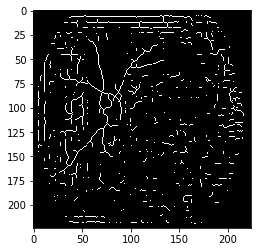

  0%|          | 1/3371 [00:00<09:36,  5.85it/s]

3533


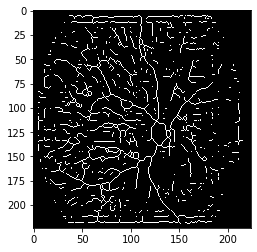

  0%|          | 2/3371 [00:00<20:03,  2.80it/s]

2603


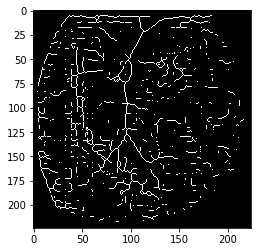

  0%|          | 3/3371 [00:00<14:44,  3.81it/s]

3170


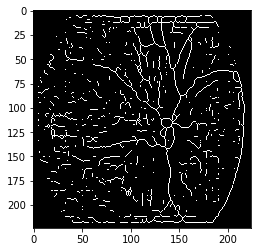

  0%|          | 4/3371 [00:00<12:18,  4.56it/s]

2119


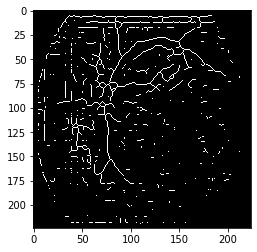

  0%|          | 5/3371 [00:01<11:05,  5.06it/s]

4142


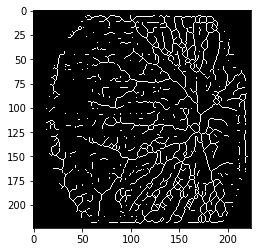

  0%|          | 6/3371 [00:01<10:22,  5.41it/s]

3684


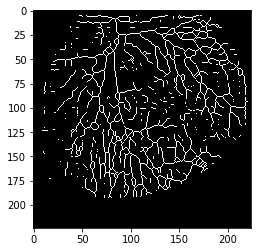

  0%|          | 7/3371 [00:01<09:54,  5.66it/s]

3864


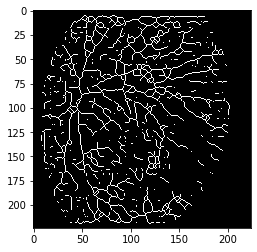

  0%|          | 8/3371 [00:01<09:29,  5.91it/s]

3080


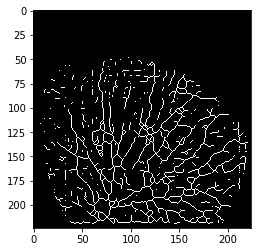

  0%|          | 9/3371 [00:01<09:14,  6.06it/s]

3217


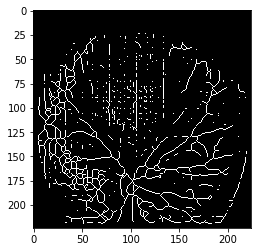

  0%|          | 10/3371 [00:01<09:15,  6.05it/s]

5595


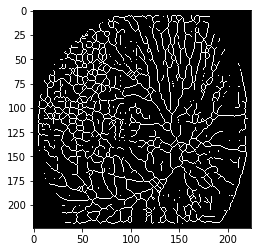

  0%|          | 11/3371 [00:02<09:11,  6.09it/s]

3824


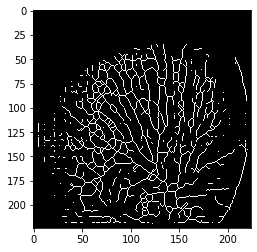

  0%|          | 12/3371 [00:02<09:12,  6.08it/s]

2995


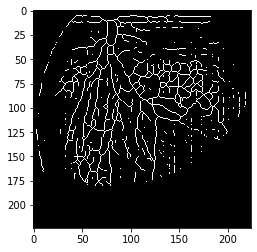

  0%|          | 13/3371 [00:02<09:10,  6.09it/s]

4938


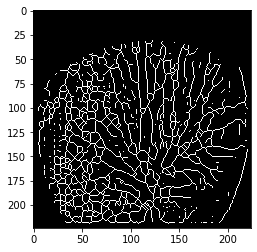

  0%|          | 14/3371 [00:02<09:08,  6.12it/s]

4425


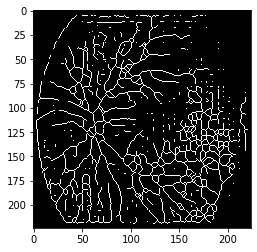

  0%|          | 15/3371 [00:02<09:07,  6.13it/s]

3368


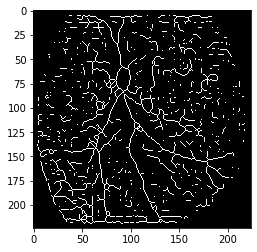

  0%|          | 16/3371 [00:02<09:02,  6.18it/s]

3907


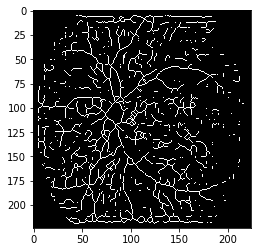

  1%|          | 17/3371 [00:03<08:55,  6.27it/s]

3273


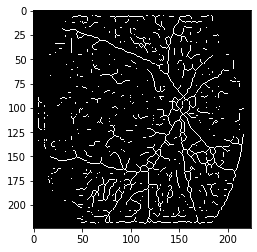

  1%|          | 18/3371 [00:03<08:50,  6.32it/s]

4439


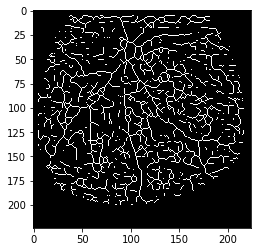

  1%|          | 19/3371 [00:03<08:53,  6.29it/s]

5985


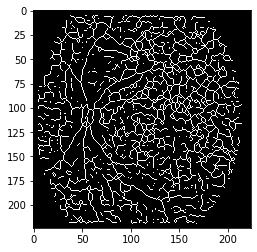

  1%|          | 20/3371 [00:03<09:01,  6.19it/s]

5237


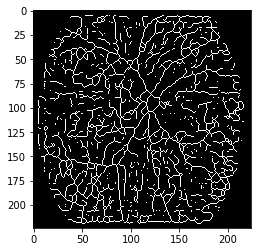

  1%|          | 21/3371 [00:03<09:02,  6.17it/s]

5284


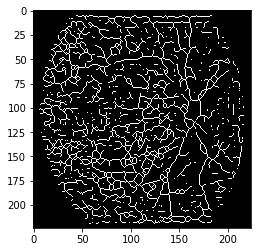

  1%|          | 22/3371 [00:03<09:07,  6.12it/s]

4657


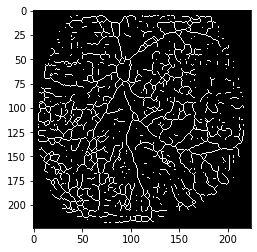

  1%|          | 23/3371 [00:04<09:03,  6.16it/s]

4282


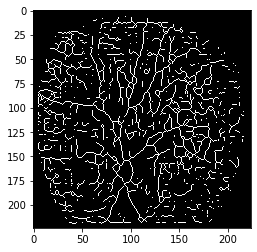

  1%|          | 24/3371 [00:04<09:09,  6.09it/s]

5074


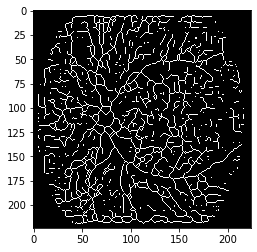

  1%|          | 25/3371 [00:04<09:14,  6.04it/s]

3853


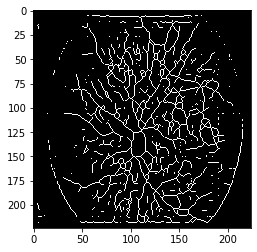

  1%|          | 26/3371 [00:04<09:17,  6.00it/s]

2539


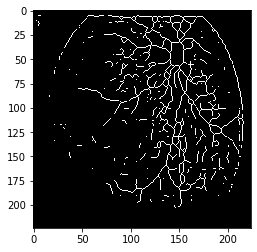

  1%|          | 27/3371 [00:04<09:23,  5.94it/s]

3786


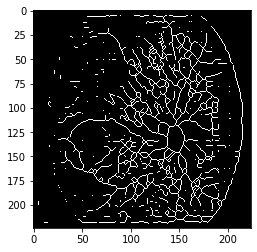

  1%|          | 28/3371 [00:04<09:28,  5.88it/s]

3723


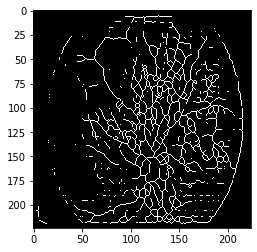

  1%|          | 29/3371 [00:05<09:26,  5.90it/s]

2994


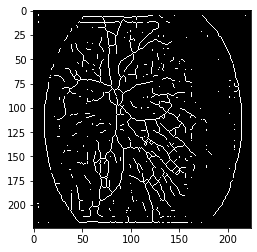

  1%|          | 30/3371 [00:05<09:29,  5.87it/s]

1655


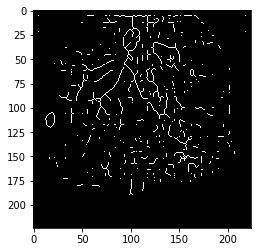

  1%|          | 31/3371 [00:05<09:13,  6.04it/s]

2196


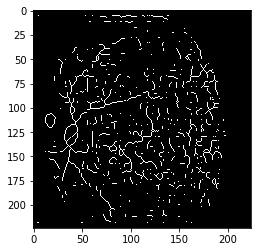

  1%|          | 32/3371 [00:05<08:58,  6.20it/s]

1657


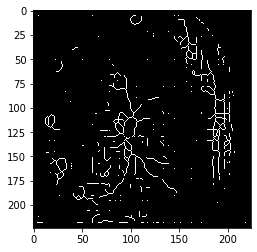

  1%|          | 33/3371 [00:05<08:49,  6.30it/s]

1402


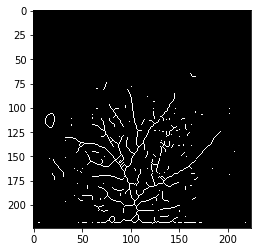

  1%|          | 34/3371 [00:05<08:45,  6.36it/s]

2539


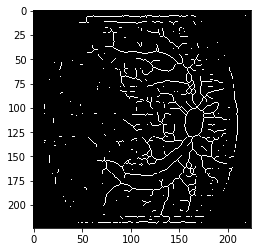

  1%|          | 35/3371 [00:05<08:41,  6.39it/s]

1299


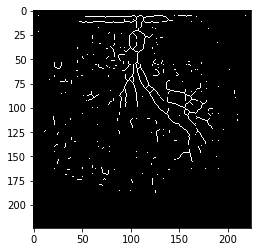

  1%|          | 36/3371 [00:06<08:36,  6.46it/s]

1542


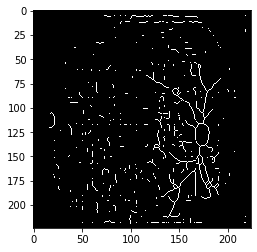

  1%|          | 37/3371 [00:06<08:45,  6.34it/s]

3117


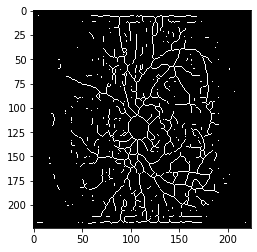

  1%|          | 38/3371 [00:06<08:47,  6.32it/s]

1260


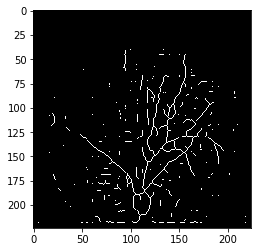

  1%|          | 39/3371 [00:06<08:44,  6.35it/s]

1816


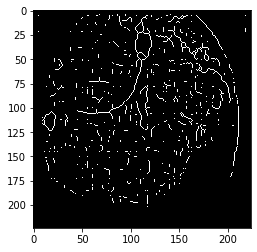

  1%|          | 40/3371 [00:06<08:49,  6.29it/s]

2308


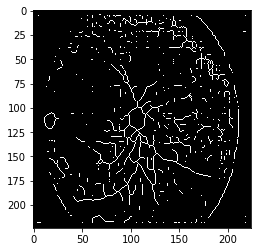

  1%|          | 41/3371 [00:06<08:47,  6.32it/s]

1695


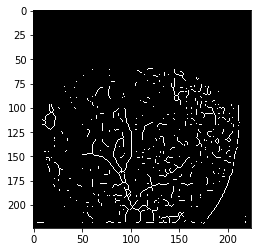

  1%|          | 42/3371 [00:07<08:43,  6.35it/s]

1802


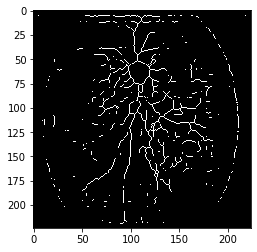

  1%|▏         | 43/3371 [00:07<08:33,  6.48it/s]

1430


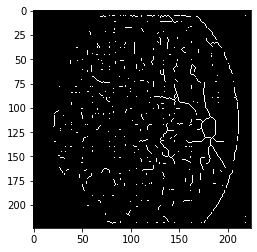

  1%|▏         | 44/3371 [00:07<08:32,  6.49it/s]

2840


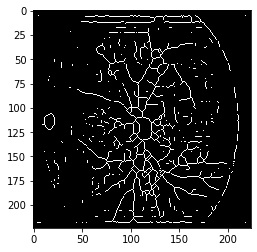

  1%|▏         | 45/3371 [00:07<08:34,  6.47it/s]

1530


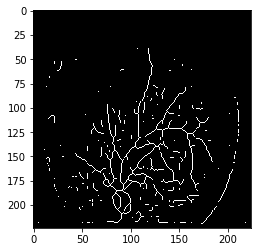

  1%|▏         | 46/3371 [00:07<08:36,  6.44it/s]

2142


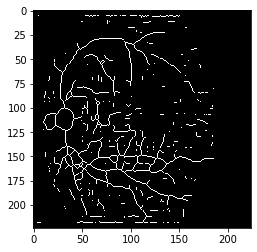

  1%|▏         | 47/3371 [00:07<08:35,  6.44it/s]

1495


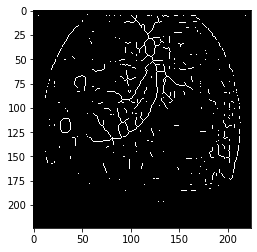

  1%|▏         | 48/3371 [00:08<08:32,  6.48it/s]

2266


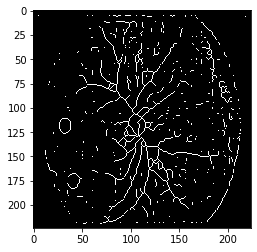

  1%|▏         | 49/3371 [00:08<08:29,  6.52it/s]

1509


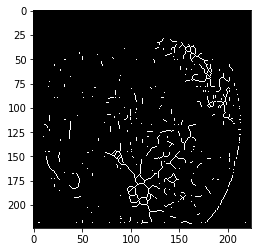

  1%|▏         | 50/3371 [00:08<08:42,  6.36it/s]

1658


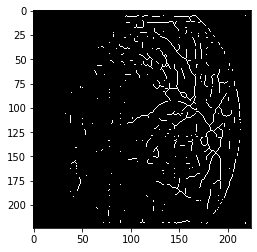

  2%|▏         | 51/3371 [00:08<08:48,  6.28it/s]

1072


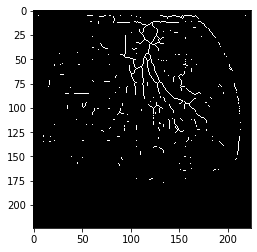

  2%|▏         | 52/3371 [00:08<08:54,  6.21it/s]

1275


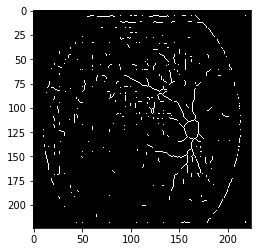

  2%|▏         | 53/3371 [00:08<08:56,  6.19it/s]

2512


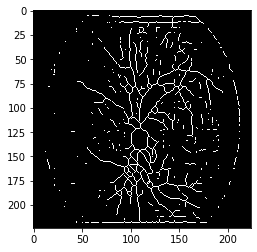

  2%|▏         | 54/3371 [00:08<09:01,  6.12it/s]

1435


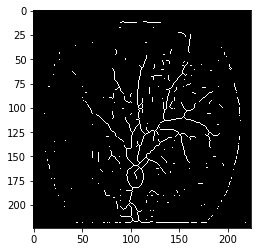

  2%|▏         | 55/3371 [00:09<08:59,  6.14it/s]

1073


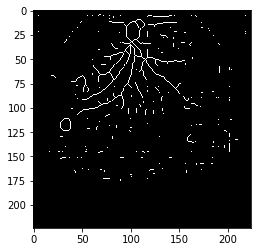

  2%|▏         | 56/3371 [00:09<08:56,  6.18it/s]

1362


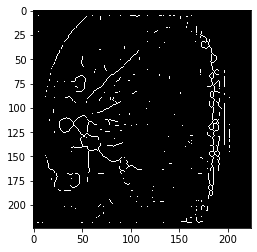

  2%|▏         | 57/3371 [00:09<08:52,  6.22it/s]

1748


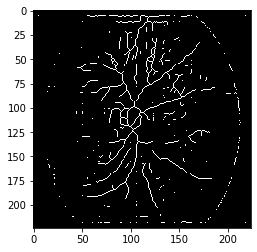

  2%|▏         | 58/3371 [00:09<08:53,  6.21it/s]

1797


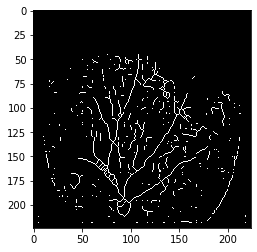

  2%|▏         | 59/3371 [00:09<08:49,  6.25it/s]

1597


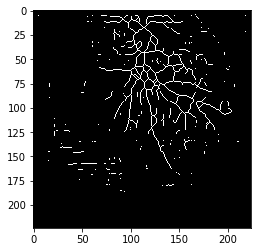

  2%|▏         | 60/3371 [00:09<08:45,  6.30it/s]

2190


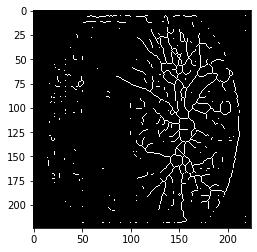

  2%|▏         | 61/3371 [00:10<08:45,  6.30it/s]

2302


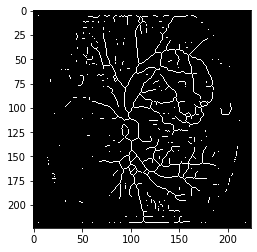

  2%|▏         | 62/3371 [00:10<08:49,  6.25it/s]

1949


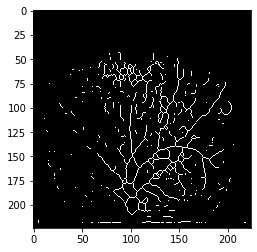

  2%|▏         | 63/3371 [00:10<08:41,  6.34it/s]

2834


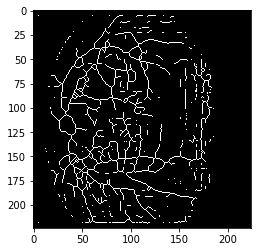

  2%|▏         | 64/3371 [00:10<08:53,  6.20it/s]

3119


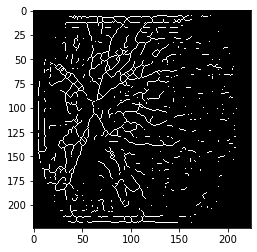

  2%|▏         | 65/3371 [00:10<08:56,  6.17it/s]

4173


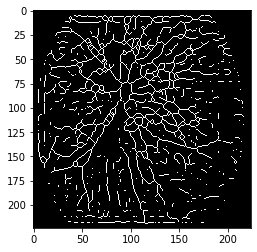

  2%|▏         | 66/3371 [00:10<08:56,  6.16it/s]

4399


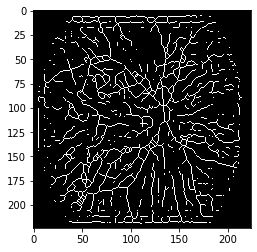

  2%|▏         | 67/3371 [00:11<08:53,  6.19it/s]

3308


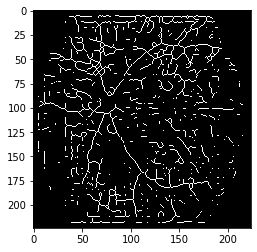

  2%|▏         | 68/3371 [00:11<09:00,  6.11it/s]

2034


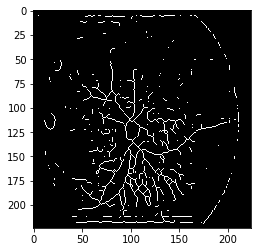

  2%|▏         | 69/3371 [00:11<08:59,  6.12it/s]

1311


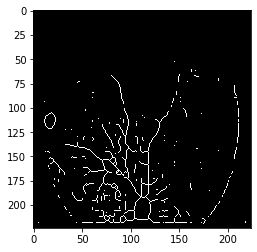

  2%|▏         | 70/3371 [00:11<08:51,  6.21it/s]

2295


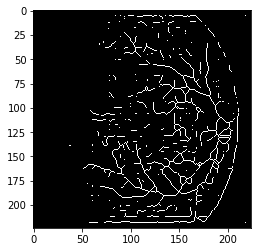

  2%|▏         | 71/3371 [00:11<08:47,  6.25it/s]

1602


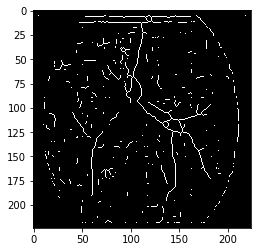

  2%|▏         | 72/3371 [00:12<15:33,  3.54it/s]

880


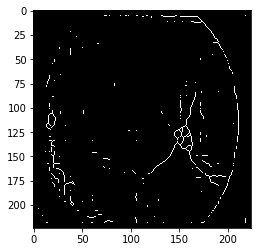

  2%|▏         | 73/3371 [00:12<13:26,  4.09it/s]

1424


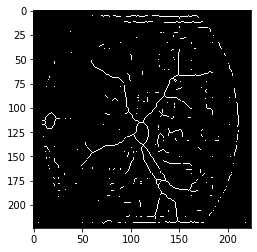

  2%|▏         | 74/3371 [00:12<12:04,  4.55it/s]

925


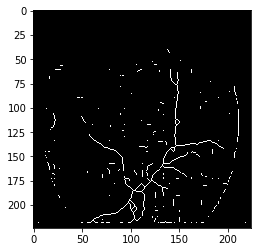

  2%|▏         | 75/3371 [00:12<10:59,  5.00it/s]

1379


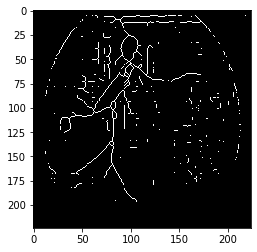

  2%|▏         | 76/3371 [00:12<10:25,  5.27it/s]

1914


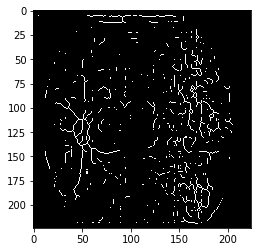

  2%|▏         | 77/3371 [00:13<10:00,  5.49it/s]

2618


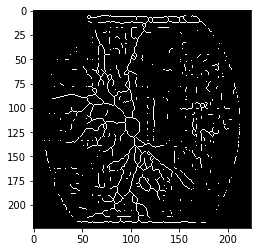

  2%|▏         | 78/3371 [00:13<09:47,  5.61it/s]

1116


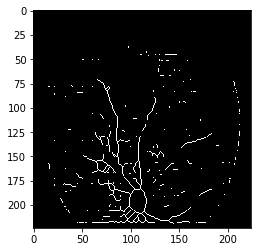

  2%|▏         | 79/3371 [00:13<09:35,  5.72it/s]

2185


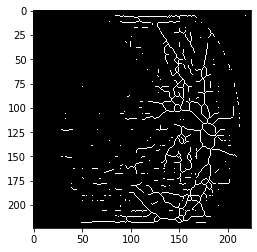

  2%|▏         | 80/3371 [00:13<09:24,  5.83it/s]

2109


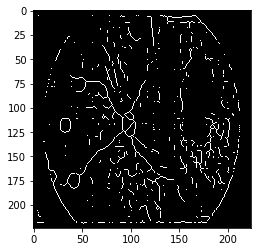

  2%|▏         | 81/3371 [00:13<09:13,  5.94it/s]

1499


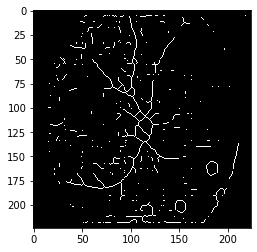

  2%|▏         | 82/3371 [00:13<09:08,  5.99it/s]

1055


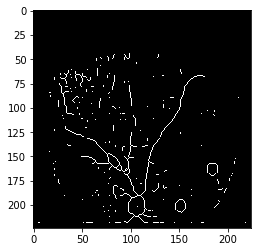

  2%|▏         | 83/3371 [00:14<09:02,  6.07it/s]

1550


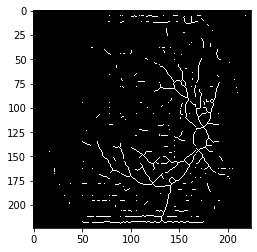

  2%|▏         | 84/3371 [00:14<09:00,  6.09it/s]

1722


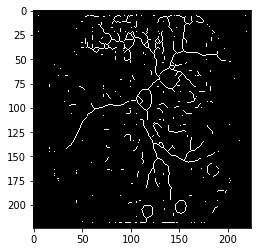

  3%|▎         | 85/3371 [00:14<08:59,  6.09it/s]

2029


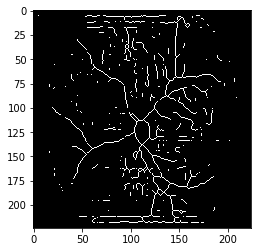

  3%|▎         | 86/3371 [00:14<08:56,  6.12it/s]

1370


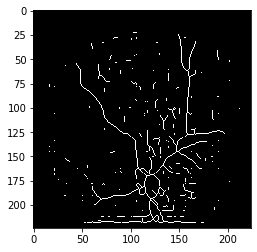

  3%|▎         | 87/3371 [00:14<08:53,  6.15it/s]

1967


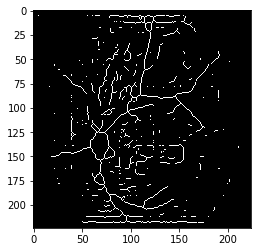

  3%|▎         | 88/3371 [00:14<08:49,  6.21it/s]

1785


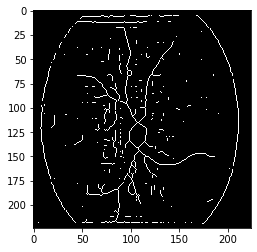

  3%|▎         | 89/3371 [00:15<08:44,  6.26it/s]

1584


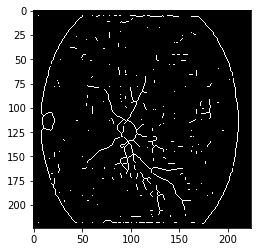

  3%|▎         | 90/3371 [00:15<08:50,  6.18it/s]

3400


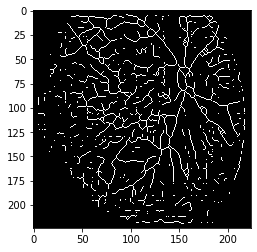

  3%|▎         | 91/3371 [00:15<08:56,  6.11it/s]

3417


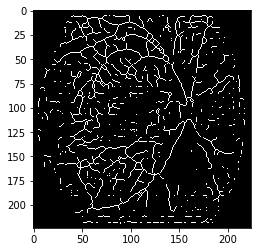

  3%|▎         | 92/3371 [00:15<08:53,  6.15it/s]

3666


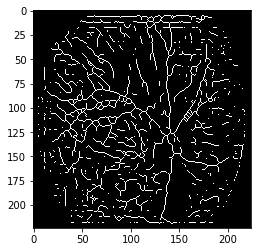

  3%|▎         | 93/3371 [00:15<08:51,  6.17it/s]

3982


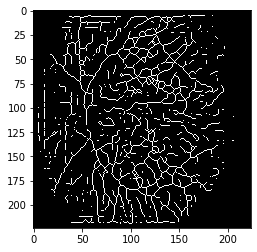

  3%|▎         | 94/3371 [00:15<08:48,  6.20it/s]

2982


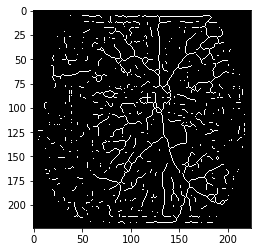

  3%|▎         | 95/3371 [00:15<08:40,  6.30it/s]

3605


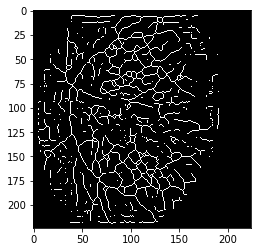

  3%|▎         | 96/3371 [00:16<08:35,  6.35it/s]

5584


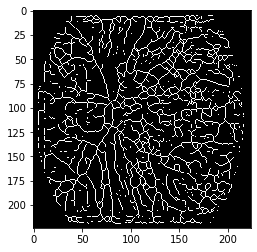

  3%|▎         | 97/3371 [00:16<09:11,  5.94it/s]


KeyboardInterrupt: 

In [85]:
apply_nonzero_count(dataset_path, True, ring_radiuses)

In [22]:
# for PIV threshold of 20 (above which I brighten when I brighten)

apply_nonzero_count(dataset_path, False, ring_radiuses, threshold=20)
apply_nonzero_count(dataset_path, True, ring_radiuses, threshold=20)

  0%|          | 8/3371 [00:00<00:46, 71.88it/s]

3371


  0%|          | 7/3371 [00:00<00:57, 58.88it/s]

3371


100%|██████████| 3371/3371 [00:55<00:00, 60.55it/s]


## Analyzing Results

Let's make some awesome graphs! We'll do black vs white scatters on a graph, with lines of best fit.

In [24]:
preds_path = "/users/riya/race/classifier_experiments/nonzero_count/"

In [86]:
nonskel_0 = pd.read_csv(preds_path + 'nonskeletonized_nonzero_count_above_0.csv')
nonskel_20 = pd.read_csv(preds_path + 'nonskeletonized_nonzero_count_above_20.csv')

skel_0 = pd.read_csv(preds_path + 'skeletonized_nonzero_count_above_0.csv')
skel_20 = pd.read_csv(preds_path + 'skeletonized_nonzero_count_above_20.csv')

In [29]:
nonskel_0_white = nonskel_0[nonskel_0['race'] == 'white']
nonskel_0_black = nonskel_0[nonskel_0['race'] == 'black']

In [ ]:
nonskel_0

In [79]:
plt.rcParams.update({'axes.titlesize': 'large'})

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/boxplot.py:391: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  **kwds,


array([<AxesSubplot:title={'center':'0-30'}, xlabel='race'>,
       <AxesSubplot:title={'center':'30-60'}, xlabel='race'>,
       <AxesSubplot:title={'center':'60-90'}, xlabel='race'>,
       <AxesSubplot:title={'center':'0-45'}, xlabel='race'>,
       <AxesSubplot:title={'center':'45-90'}, xlabel='race'>,
       <AxesSubplot:title={'center':'0-159'}, xlabel='race'>],
      dtype=object)

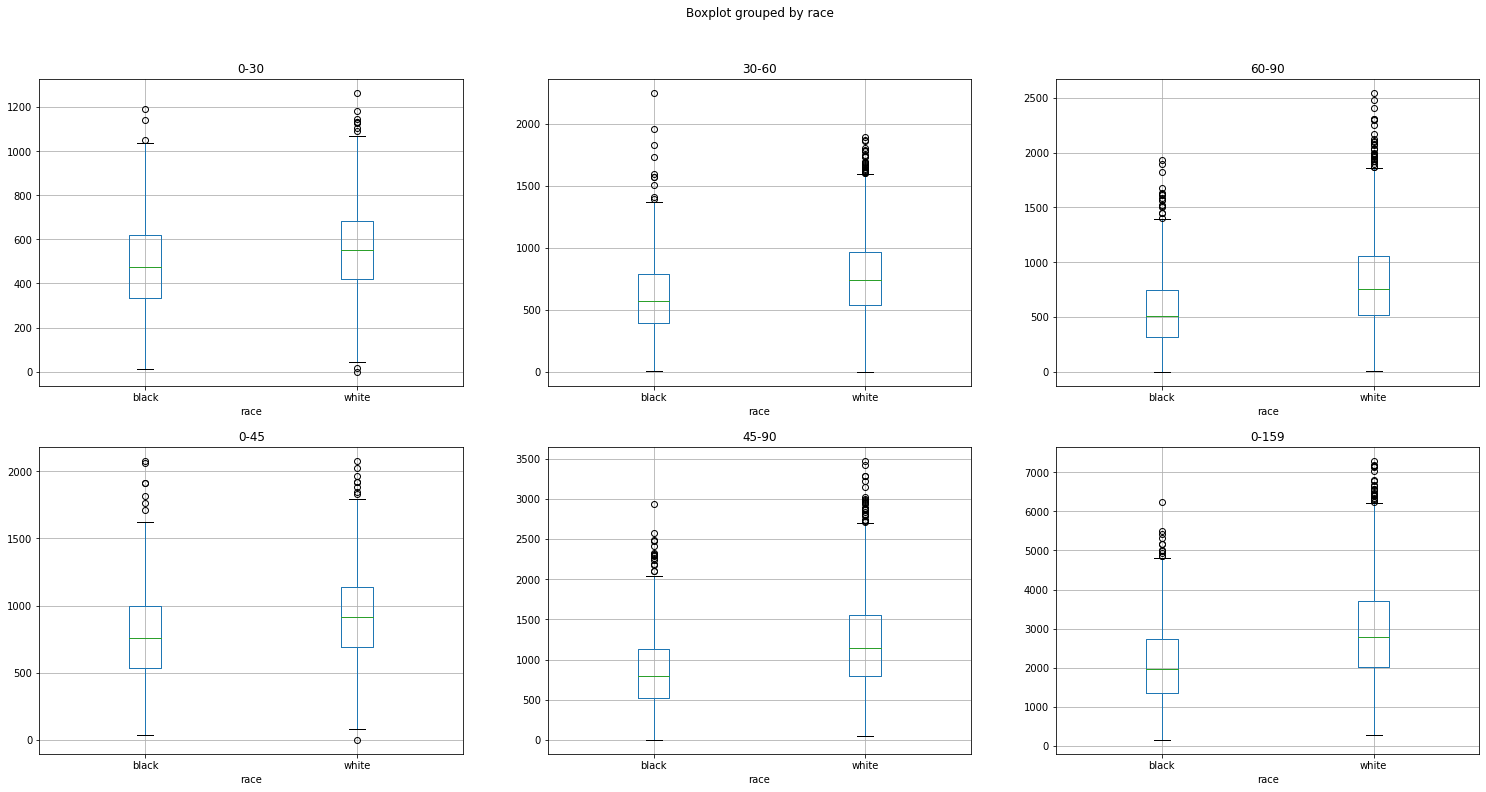

In [87]:
fig, axs = plt.subplots(2,3,figsize=(25, 12.5), sharey=False)
nonskel_20.boxplot(['0-30', '30-60', '60-90','0-45', '45-90','0-159'], by = 'race', ax = axs)

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/boxplot.py:391: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  **kwds,


array([<AxesSubplot:title={'center':'0-30'}, xlabel='race'>,
       <AxesSubplot:title={'center':'30-60'}, xlabel='race'>,
       <AxesSubplot:title={'center':'60-90'}, xlabel='race'>,
       <AxesSubplot:title={'center':'0-45'}, xlabel='race'>,
       <AxesSubplot:title={'center':'45-90'}, xlabel='race'>,
       <AxesSubplot:title={'center':'0-159'}, xlabel='race'>],
      dtype=object)

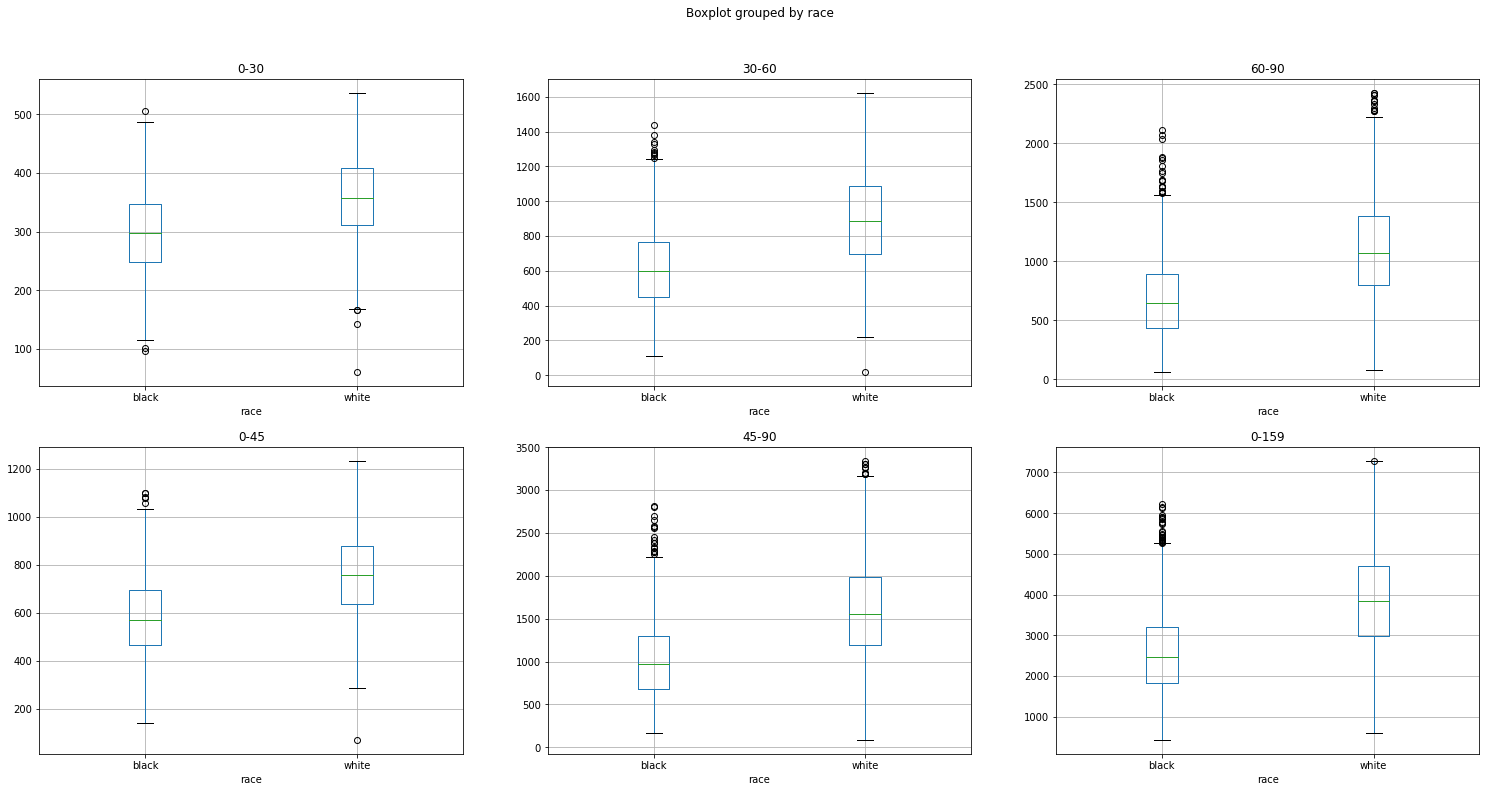

In [88]:
fig, axs = plt.subplots(2,3,figsize=(25, 12.5), sharey=False)
skel_20.boxplot(['0-30', '30-60', '60-90','0-45', '45-90','0-159'], by = 'race', ax = axs)

### Macula Analysis

In [26]:
image_size = (224, 224)

In [27]:
center_mask = np.full((224, 224), 255, dtype=np.uint8)

In [31]:
x_pos = int(image_size[0]/2)

In [32]:
cv2.rectangle(center_mask, (0,image_size[1]), (image_size[1], x_pos), (0, 0, 0), -1) 

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)

In [108]:
cv2.rectangle(center_mask, (0,224), (112, 0), (0, 0, 0), -1) 

array([[  0,   0,   0, ..., 255, 255, 255],
       [  0,   0,   0, ..., 255, 255, 255],
       [  0,   0,   0, ..., 255, 255, 255],
       ...,
       [  0,   0,   0, ..., 255, 255, 255],
       [  0,   0,   0, ..., 255, 255, 255],
       [  0,   0,   0, ..., 255, 255, 255]], dtype=uint8)

In [113]:
cv2.rectangle(center_mask, (112,224), (224, 0), (0, 0, 0), -1) 

array([[255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       ...,
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0]], dtype=uint8)

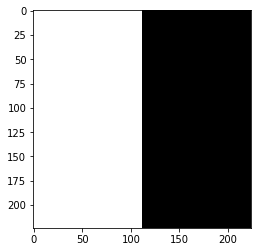

In [114]:
plt.imshow(center_mask, cmap = 'gray')

In [3]:
from utils import macula_focus

In [4]:
img_test = image_from_id("/users/riya/race/dataset/segmentations/", '7571.bmp')

In [15]:
return_img = macula_focus(img_test, False, 'os', 'inferior', 20, 'show_macula')

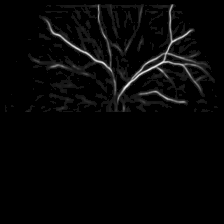

In [16]:
return_img

In [ ]:
def macula_focus(img, skeleton, eye_direction, eye_view, brighten_sum, region,
                     none_thresh = 0, image_size = (224, 224)):
    
    img, _ , modified_img = process_skeletonize(img, skeleton) # image size given
    
    # develop mask
    
    select_macula = isolating_macula_mask(eye_direction, eye_view)
    mask_macula = cv2.bitwise_not(select_macula)
    
    if (region == 'show_macula'): # could be for ring or not for ring
        modified_img2 = cv2.bitwise_or(modified_img, modified_img, mask=select_macula)
        
    elif (region == 'hide_macula'):
        # masking the center region
        modified_img2 = cv2.bitwise_or(modified_img, modified_img, mask=mask_macula)
    
    # now for brightening code
    modified_img3 = apply_threshold(modified_img2, 'add', none_thresh, brighten_sum, thresh_type = 'below') # yay default. Not dulling.
    final_img = substitute_channels(img, modified_img3)
    
    return final_img

I won't use the brighten feature right now. I might repeat systemic brightening experiment with just the macular regions (no training new models, just performing inference).